In [1]:
# INTRO:
# 1- Loaded Raw Pulsations in filter I from 15/11/2021  
# 3- Filtered out frequencies higher than 100 d^(-1) (--> Periods shorter than 15 min)
# 4- Loaded filtered signal in Period04
# 5- Finding Frequencies, Amplitudes and Phases with Period04
# 6- First frequencies, amplitudes and phases found with Period04
#     used to generate a synthetic pulsation signal

In [2]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [3]:
# Load I Transit DataFrame
transI_fn = "../TransPuls/TransI/Measurements_Transito_Banda_I_Dia_16_Referencia_BD_36_488.csv"
transI_df = pd.read_csv(transI_fn, sep=";")

# Load the I Transit rel_flux_T1 data signal acquired on 16-17/11/2021
transI = np.array(transI_df["rel_flux_T1"])
print(len(transI))
transI_df

260


,,Label,slice,Saturated,J.D.-2400000,JD_UTC,JD_SOBS,HJD_UTC,BJD_TDB,AIRMASS,...,Width_T4,X-Width_T4,Y-Width_T4,Angle_T4,Roundness_T4,rel_flux_T1_f,rel_flux_err_T1_f,rel_flux_T1_f_model,rel_flux_T1_f_residual,rel_flux_err_T1_f_residual
0,1,WASP-33-0001I_out.fit.gz,1,0,59535.43442,2459535.434,2459535.434,2459535.440,2459535.440,1.005894,...,33.120436,36.178901,30.061970,11.410825,0.960527,2.749677,0.001502,2.743105,0.006572,0.001502
1,2,WASP-33-0002I_out.fit.gz,2,0,59535.43521,2459535.435,2459535.435,2459535.440,2459535.441,1.005552,...,31.849911,33.503951,30.195871,353.503373,0.988699,2.745979,0.001503,2.743105,0.002874,0.001503
2,3,WASP-33-0003I_out.fit.gz,3,0,59535.43600,2459535.436,2459535.436,2459535.441,2459535.442,1.005131,...,32.409810,35.578732,29.240889,347.017370,0.953582,2.735264,0.001485,2.743105,-0.007841,0.001485
3,4,WASP-33-0004I_out.fit.gz,4,0,59535.43678,2459535.437,2459535.437,2459535.442,2459535.443,1.004745,...,32.417469,34.697460,30.137479,354.033749,0.979533,2.751081,0.001512,2.743105,0.007976,0.001512
4,5,WASP-33-0005I_out.fit.gz,5,0,59535.43757,2459535.438,2459535.437,2459535.443,2459535.444,1.004375,...,34.646220,38.852792,30.439647,1.035797,0.942659,2.746094,0.001497,2.743105,0.002989,0.001497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,256,WASP-33-0256I_out.fit.gz,256,0,59535.63639,2459535.636,2459535.636,2459535.642,2459535.642,1.573038,...,39.172339,41.677650,36.667028,20.617531,0.971303,2.733572,0.001583,2.743105,-0.009533,0.001583
256,257,WASP-33-0257I_out.fit.gz,257,0,59535.63719,2459535.637,2459535.637,2459535.642,2459535.643,1.580053,...,39.561409,42.026587,37.096231,21.470022,0.971243,2.754446,0.001602,2.743105,0.011341,0.001602
257,258,WASP-33-0258I_out.fit.gz,258,0,59535.63799,2459535.638,2459535.638,2459535.643,2459535.644,1.587474,...,40.164471,42.234014,38.094928,25.082668,0.974256,2.735530,0.001582,2.743105,-0.007575,0.001582
258,259,WASP-33-0259I_out.fit.gz,259,0,59535.63879,2459535.639,2459535.639,2459535.644,2459535.645,1.594784,...,42.447346,44.465714,40.428977,30.434741,0.962008,2.742911,0.001601,2.743105,-0.000194,0.001601


In [4]:
times = np.array(transI_df["J.D.-2400000"])
ti = times[0]
tf = times[len(transI)-1]

acq_duration = tf - ti # Transit B total DAQ duration [days] on 16-17/11/2021 
fs = 1 / (acq_duration / len(transI)) # pulsation per day
fs

1267.3035680060939

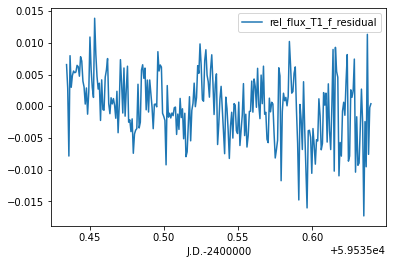

In [5]:
pulsI_from_transit = transI_df["rel_flux_T1_f_residual"]
transI_df.plot(x="J.D.-2400000", 
               y="rel_flux_T1_f_residual", 
               marker=None, linestyle='-');

In [6]:
cutoff = 100 # 24h/d*60min/h / 100c/d = 14.4 min/c -> cutoff periods lower than ~15min
order = 3
def butterworth_lowpass(data, fs, cutoff, order):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return np.array(y)

In [7]:
filtered_Ipuls = butterworth_lowpass(pulsI_from_transit, fs, cutoff, order)

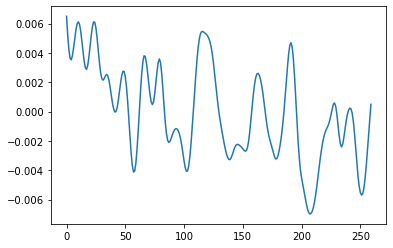

In [8]:
plt.plot(filtered_Ipuls)
transI_df["filtered_pulsations"] = filtered_Ipuls

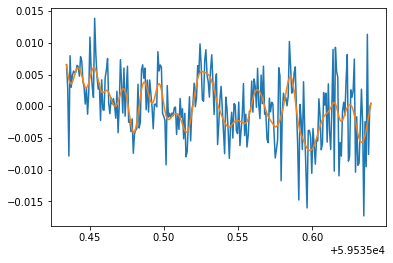

In [9]:
plt.plot(times, pulsI_from_transit); 
plt.plot(times, filtered_Ipuls);

In [10]:
transI_df.to_csv(path_or_buf="./20220212_TransI_C3asRef_filt.csv", sep=" ")

In [11]:
# Now that the frequencies have already been deduced, we will generate the signal using 
#  the found frequencies, amplitudes and phases, to verify that the found quantities 
#  make sense.

In [12]:
def generate_signal_from_sins(times, sins):
    """
    Generate signal from a list of sinus, each of them 
    containing frequency, amplitude and phase
    """
    t = np.array(times)
    generated_pulsations = np.zeros((len(t)), dtype=np.float32)
    for sin in sins:
        f = sin[0]    
        A = sin[1]
        ph = sin[2]
        generated_pulsations = generated_pulsations + A * np.sin(2*np.pi*(f*t + ph))
    return generated_pulsations

In [13]:
#Frequencies f: Units:[d^(-1)], found with Period04, for signal filtered_Ipuls

# sins: [[f, A, phase]]
sins = [[22.17738, 0.0051749717, 0.156206],
        [11.6979587, 0.00364071015, 0.889669],
        [33.3879238, 0.00315459954, 0.662236],
        [7.55493166, 0.00193885825, 0.58376],
        [68.9692149, 0.00166916772, 0.344942],
        [16.8158156, 0.00163625147, 0.048102],
        [41.1865629, 0.00116035458, 0.609575],
        [27.5389445, 0.00114954562, 0.592179],
        [54.103059, 0.00123522241, 0.0317532],
        [73.8433643, 0.00106554467, 0.466689],
        [85.2976156, 0.000998005791, 0.842594],
        [79.6923437, 0.000883774194, 0.0109689],
        [48.9852021, 0.00079500579, 0.0552689],
        [37.5309508, 0.000615593108, 0.282519],
        ]

generated_pulsationsI = generate_signal_from_sins(times, sins)

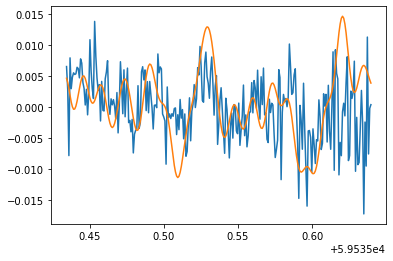

In [14]:
plt.plot(times, pulsI_from_transit);
plt.plot(times, generated_pulsationsI);

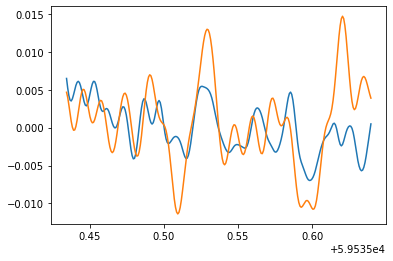

In [15]:
plt.plot(times, filtered_Ipuls); 
plt.plot(times, generated_pulsationsI);

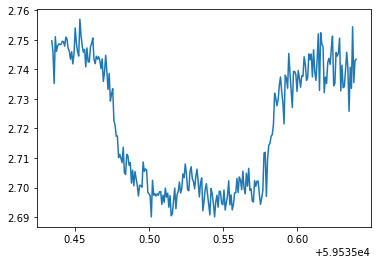

In [16]:
# Now the objective is subtracting the found frequencies to the complete signal, 
# in order to be able afterwards to improve the recognition of the transit
# Load the Transit I data signal acquired on 16-17/11/2021
transitI_dirty = np.array(transI_df["rel_flux_T1"])
plt.plot(times, transitI_dirty); 

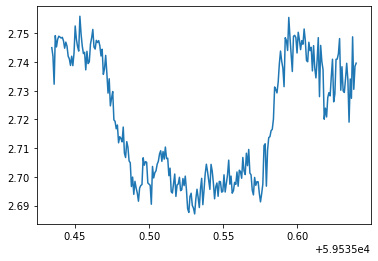

In [17]:
# TransitB with star pulsations seen in filter-B, being removed
clean_transitI = transitI_dirty - generated_pulsationsI
plt.plot(times, clean_transitI);

In [18]:
transI_df["clean_transitI"] = clean_transitI
transI_df.to_csv(path_or_buf="./202202012_TransI_C3asRef_filt.csv", sep=" ")